In [39]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from diskmodels import profilecirc
from diskfit import likelihood, utils
from IPython.display import display, Math
from ultranest.plot import PredictionBand

In [40]:
z = 0.0568
cont = np.array([8.74764134e-08, -2.43552278e+00, 7.81167947e-17])

def power_law(wl, A, k, C):
    return A*(wl/(1+z))**k+C

def power_law(wl, A, k, C):
    return A*(wl/(1+z))**k+C

def model_linefit_circ_fixeddoublet_freeamplitudes_Halpha(theta, w, y, yerr, lines, fixed, fitted):
    fitted = dict(zip(fitted.keys(),theta)) 
    params = {**fitted, **fixed}
    x = w/(1+params['z'])
    xib0 = (params['xi2']-params['xi1'])*params['xib']+params['xi1'] 
    diskmodel = profilecirc.profile(params['maxstep'],params['xi1'],params['xi2'],params['broad'],params['q1'],params['q2'],xib0,params['angi']%180,params['anglam'],params['t0'],params['eta'],params['version'],params['amp'],params['narms'],params['aobs']%360,params['pitch'],params['width'],params['xispin'],params['xispout'],params['nstep'],params['relativistic'],params['olambda'],params['npix'],x)
    widths = np.hstack((np.ones(len(lines))*params['narrowwidth'],np.ones(len(lines))*params['narrowwidth2'])) 
    lineprofs1 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[:len(lines)],params['ratios'])   
    lineprofs2 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[len(lines):2*len(lines)],params['ratios'])    
    amps = [params['Halphaflux'],params['NIIbflux'],params['SIIbflux']]
    narrowmodel1 = lineprofs1[0] * amps[0]
    for line,amp in zip(lineprofs1[1:],amps[1:]):
        narrowmodel1+=line*amp 
    narrowmodel2 = lineprofs2[0] * amps[0]
    for line,amp in zip(lineprofs2[1:],amps[1:]):
        narrowmodel2+=line*amp 
    narrowmodel = np.sum((narrowmodel1,narrowmodel2),axis=0)
    diskout = diskmodel*params['diskflux']
    model = np.sum((diskout,narrowmodel),axis=0)
    return model

class log_prior(object):
    def __init__(self, mins, maxes):
        self.mins = mins
        self.maxes = maxes
    def __call__(self, theta): 
        if np.any(theta<self.mins) or np.any(theta>self.maxes): 
            return -np.inf
        return 0.0

class logprob_circ_fixeddoublet_freeamplitudes_Halpha(object):
    def __init__(self, x, y, yerr, lines, fixed, fitted, mins, maxes):   
        self.x = x
        self.y = y
        self.yerr = yerr
        self.lines = lines
        self.fixed = fixed
        self.fitted = fitted
        self.mins = mins
        self.maxes = maxes
        self.log_prior = log_prior(self.mins, self.maxes)
    def __call__(self,theta):
        lp = self.log_prior(theta)
        like = loglikelihood_circ_fixeddoublet_freeamplitudes_Halpha(theta, self.x, self.y, self.yerr, self.lines, self.fixed, self.fitted)
        if np.any(np.isnan(like)):
            #return np.full(len(like),1e10+lp)
            return -np.inf   
        #print(like,lp)
        return like+lp 
    def test(self,theta):
        modelout = model_linefit_circ_fixeddoublet_freeamplitudes_Halpha(theta, self.x, self.y, self.yerr, self.lines, self.fixed, self.fitted) 
        return modelout 
    def plot(self,theta):
        diskout,narrowout = plot_linefit_circ_fixeddoublet_freeamplitudes_Halpha(theta, self.x, self.y, self.yerr, self.lines, self.fixed, self.fitted) 
        return diskout,narrowout

fn = 'Files/2020zso.txt'
wl, flux = np.loadtxt(fn, usecols=(0, 1), unpack=True)
flux -= power_law(wl, *cont)
flux *= 1e18

olambda = 6563
wavemin = 6150
wavemax = 7000
wave = wl/(1+z)
indwave = np.argwhere((wave>wavemin)&(wave<wavemax)&~np.isnan(flux))[:,0]
wl = np.asarray(wl[indwave],dtype=np.float64)
fluxerr = np.ones(flux.shape)*np.median(np.abs(flux[1:]-flux[:-1]))
flux = flux[indwave]
fluxerr = 3*fluxerr[indwave]
npix = wl.shape[0]

maxstep = 400 # Maximum number of integration steps (integer)
nstep = 100 # integration steps (integer, </= 400)
relativistic = 'y' #  include relativistic effects? (y/n) [y]
normalization = 'max' # profile normalization scheme (max/flux/none) [max]
q1 = 1.9 #inner emissivity powerlaw index
q2 = 1.9 #outer emissivity powerlaw index
xib = 0.6 #power-law index break radius (XIB=0 causes Q=Q2 throughout)
t0 = 1e-8   # optical depth normalization (0=no wind)
eta = 0.8 #optical depth power-law index
anglam = 8 #wind opening angle (degrees)
version = 'f' #formula for escape probability (f=Flohic, m=Murray)
narms = 1 #number of arms (integer)
pitch = -20 #pitch angle of spiral pattern (+ve=leading, -ve=trailing)
width = 40 #angular width of arm (degrees)
xispin = 1000 #inner spiral arm radius radius (GM/c^2, 0=XI1)
xispout = 5000 #outer spiral arm radius radius (GM/c^2, 0=XI2)
narrowwidth = 1.7 # Width of component 1 of broad line in Angstroms
narrowwidth2 = 0.9 # Width of component 2 of broad line in Angstroms
narrowfrac = 0.2 #Amplitude fraction the two narrow line components

angimin, angimax = -360, 360
xi1min, xi1max = 50, 10000
xi2min, xi2max = 100, 25000
broadmin, broadmax = 0, 2000
ampmin, ampmax = -1e-12, 5.0
pitchmin, pitchmax = -60, 60
aobsmin, aobsmax = -720, 360*3
narrowwidthmin, narrowwidthmax = 0.1, 15.0
narrowwidth2min, narrowwidth2max = 0.1, 12.0
narrowfracmin, narrowfracmax = 0.1, 5.0
anglammin, anglammax = 2.0, 40
t0min, t0max = 1e-10, 1e2
etamin, etamax = -1.5, 1.5
Halphafluxmin, Halphafluxmax = 12, 300
NIIbfluxmin, NIIbfluxmax = 0.0, 8
SIIbfluxmin, SIIbfluxmax = 0.0, 300
diskfluxmin, diskfluxmax = 1, 500

diskmins = [
xi1min,xi2min,broadmin,angimin,narrowfracmin,narrowwidthmin,narrowwidth2min,Halphafluxmin,NIIbfluxmin,SIIbfluxmin,diskfluxmin,ampmin,aobsmin]
diskmax = [
xi1max,xi2max,broadmax,angimax,narrowfracmax,narrowwidthmax,narrowwidth2max,Halphafluxmax,NIIbfluxmax,SIIbfluxmax,diskfluxmax,ampmax,aobsmax]
NIIa = 6549.86
Halpha = 6564.614
NIIb = 6585.27
SIIa = 6718.29
SIIb = 6732.68
lines = [Halpha,NIIa,NIIb,SIIa,SIIb]
NIIb_NIIa = 2.95
SIIb_SIIa = 1.3
ratios = [NIIb_NIIa,SIIb_SIIa]
Halphaflux = 34
NIIbflux = 0
diskflux = 12
SIIbflux = 0

angi = 7 #disk inclination angle (degrees)
xi1 = 1000 #inner disk radius (GM/c^2)
xi2 = 4400 #outer disk radius (multiple of xi1)
broad = 200 #broadening parameter (km/s)

amp  = 2
aobs = 150
fitted_labels = ['xi1','xi2','broad','angi','narrowfrac','narrowwidth','narrowwidth2','Halphaflux','NIIbflux','SIIbflux','diskflux', 'amp', 'aobs']
names = [r'$\xi_1$', r'$\xi_2$', r'$\sigma$', r'$i$',
         r'$nf$', r'$nw_1$', r'$nw_2$', r'$f_\text{H}$',
         r'$f_\text{S}$', r'$f_\text{N}$', r'$f_\text{d}$', r'$\alpha$', r'$\phi$']

initial = [5.07485530e+01, 4.37105464e+02, 1.39529219e+03, 3.26526185e+01,
 1.00000000e-01, 4.91042367e+00, 4.27461042e-01, 3.29318059e+01,
 1.16147639e+01, 7.86478574e+00, 4.26814063e+00, 1.44310147e+00,
 5.01148362e+01]

#initial = [xi1,xi2,broad,angi,narrowfrac,narrowwidth,narrowwidth2,Halphaflux,NIIbflux,SIIbflux,diskflux,amp,aobs]
fitted = dict(zip(fitted_labels,initial))

fixed_labels = ['z','ratios','q1','q2','xib','maxstep','version','narms','pitch','width','xispin','xispout','nstep','relativistic','olambda','npix','SIIbflux','anglam','t0','eta']
fixed_values = [z,ratios,q1,q2,xib,maxstep,version,narms,pitch,width,xispin,xispout,nstep,relativistic,olambda,npix,SIIbflux,anglam,t0,eta]
fixed = dict(zip(fixed_labels,fixed_values))

lp = logprob_circ_fixeddoublet_freeamplitudes_Halpha(wl, flux, fluxerr, lines, fixed, fitted, diskmins, diskmax)

In [41]:
nwalkers, ndim = (50, len(initial))
filename ='Files/emcee-2020zso.h5'
backend = emcee.backends.HDFBackend(filename, read_only=True)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lp, backend=backend)
flat_samples = sampler.get_chain(discard=5000, flat=True)

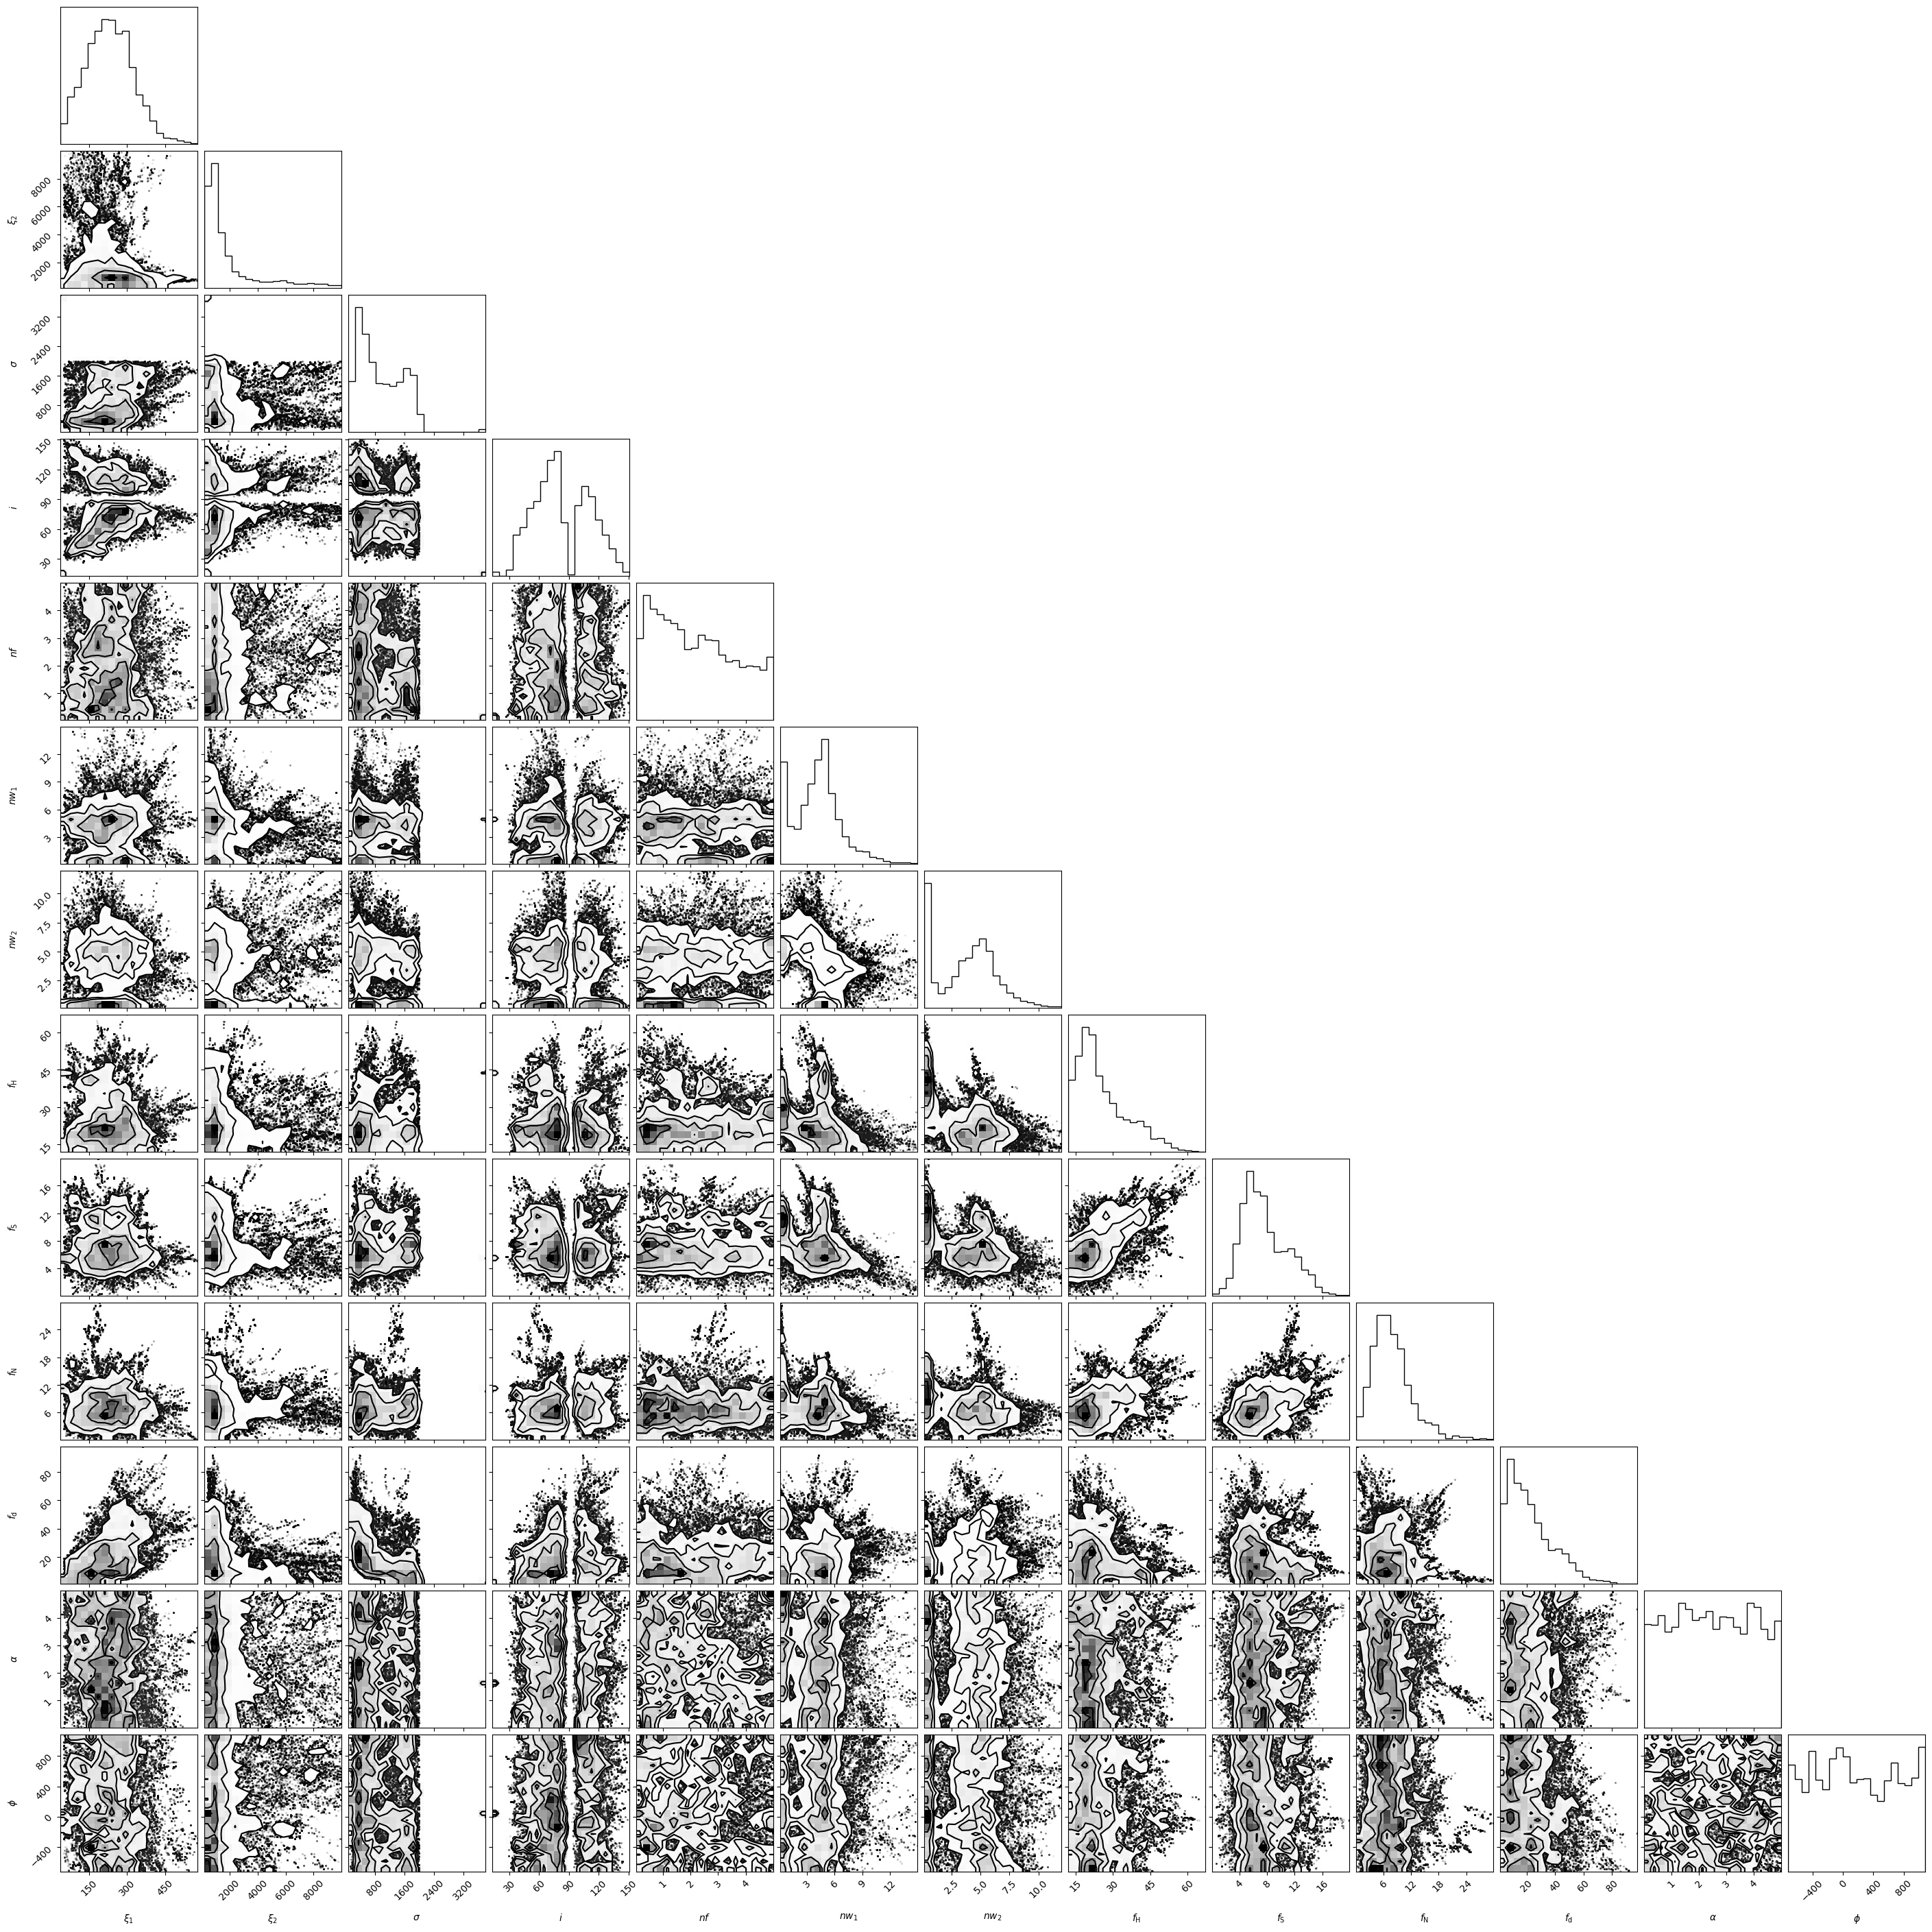

In [42]:
fig = corner.corner(flat_samples, labels=names)
plt.savefig('2020zso-corner.png')
plt.show()

In [5]:
mcmc_soln = []
for i,l in enumerate(fitted_labels):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], fitted_labels[i])
    display(Math(txt))
    
    mcmc_soln.append(mcmc[1])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [37]:
band = PredictionBand(wl/(1+fixed['z']))
inds = np.random.randint(len(flat_samples), size=10)
for ind in inds:
    sample = flat_samples[ind]
    try:
        modelfit = lp.test(sample)
        band.add(modelfit)
        #plt.plot(wl/(1+fixed['z']),modelfit,alpha=0.1)
    except:
        continue
band.line(color='k',label='model')
# add 1 sigma quantile
band.shade(q=0.1, color='k', alpha=0.5)
# add wider quantile (0.01 .. 0.99)
band.shade(q=0.15, color='gray', alpha=0.2)

plt.plot(wl/(1+fixed['z']),flux+7,label='data')
#plt.title('Best Fit by Emcee -- AT2020zso')
plt.legend(fontsize=14)
plt.xlabel("Rest $\lambda$ ($\AA$)"); plt.ylabel(r'f$_\lambda$ ' + ' (10$^{18}\cdot$erg/s/cm$^2$/Hz)')
plt.title(r'$\Delta t=6.8$ d')
plt.savefig('emcee.png')
plt.show()